## Importacion de datos

In [71]:
!pip install tensorflow

  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)
  Using cached gast-0.6.0-py3-none-any.whl (21 kB)
  Using cached ml_dtypes-0.5.1-cp310-cp310-win_amd64.whl (209 kB)
     ---------------------------------------- 4.3/4.3 MB 746.6 kB/s eta 0:00:00
  Using cached protobuf-5.29.3-cp310-abi3-win_amd64.whl (434 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl (71 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl (5.5 MB)
  Using cached absl_py-2.1.0-py3-none-any.whl (133 kB)
     ---------------------------------------- 3.0/3.0 MB 501.8 kB/s eta 0:00:00
     -------------------------------------- 26.4/26.4 MB 597.6 kB/s eta 0:00:00
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ---------------------------------------- 1.3/1.3 MB 676.1 kB/s eta 0:00:00
     ---------------------------------------- 1.5/1.5 MB 1.1 MB/s eta 0:00:00
     ------------------------------------ 296.5/296.5 kB 9

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.reset_option("display.max_rows")
pd.set_option('display.max_columns', None)
filename = 'au_recuperacion.csv'

df = pd.read_csv(filename)
df

,ag_cabeza,ag_colas_zn,ag_concentrado_pb_lag2,ag_concentrado_pb_lag3,ag_concentrado_pb_lag4,ag_concentrado_pb_lag5,ag_concentrado_pb_lag6,ag_concentrado_pb_lag9,ag_concentrado_pb_lag12,ag_concentrado_pb_ley_lag1,ag_concentrado_pb_ley_lag3,ag_concentrado_pb_ley_lag4,ag_concentrado_pb_ley_lag5,ag_concentrado_pb_ley_lag6,ag_concentrado_pb_ley_lag9,ag_concentrado_pb_ley_lag11,ag_concentrado_pb_ley_lag12,ag_concentrado_zn_ley_lag12,au_recuperacion
0,807.940007,942.316754,12418.457575,14555.034535,15909.362330,14943.145948,13527.175146,13544.810526,11450.710542,13005.302412,14555.034535,15909.362330,14943.145948,13527.175146,13544.810526,12263.137734,11450.710542,806.072461,83.673031
1,587.060001,955.582004,13005.302412,12418.457575,14555.034535,15909.362330,14943.145948,14817.123206,12263.137734,13141.531748,12418.457575,14555.034535,15909.362330,14943.145948,14817.123206,11086.858835,12263.137734,850.078887,71.639108
2,578.719997,1111.958294,13141.531748,13005.302412,12418.457575,14555.034535,15909.362330,15323.725253,11086.858835,13015.503809,13005.302412,12418.457575,14555.034535,15909.362330,15323.725253,13544.810526,11086.858835,1055.338111,61.733124
3,896.220006,1193.116874,13015.503809,13141.531748,13005.302412,12418.457575,14555.034535,13527.175146,13544.810526,12500.569497,13141.531748,13005.302412,12418.457575,14555.034535,13527.175146,14817.123206,13544.810526,1174.511108,78.127386
4,546.600003,1426.681315,12500.569497,13015.503809,13141.531748,13005.302412,12418.457575,14943.145948,14817.123206,13412.076383,13015.503809,13141.531748,13005.302412,12418.457575,14943.145948,15323.725253,14817.123206,1238.088423,64.260562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405,448.900001,684.767460,9458.942890,12797.360110,14458.389904,11451.821197,11206.434889,10162.782265,8290.059048,11644.664718,12797.360110,14458.389904,11451.821197,11206.434889,10162.782265,9478.674881,8290.059048,523.049123,65.460849
406,447.020004,364.807686,11644.664718,9458.942890,12797.360110,14458.389904,11451.821197,10189.139900,9478.674881,9667.431613,9458.942890,12797.360110,14458.389904,11451.821197,10189.139900,8803.110463,9478.674881,574.330406,74.421502
407,497.169998,354.333683,9667.431613,11644.664718,9458.942890,12797.360110,14458.389904,12249.068907,8803.110463,6911.827347,11644.664718,9458.942890,12797.360110,14458.389904,12249.068907,10162.782265,8803.110463,567.301874,75.692150
408,389.980000,359.898402,6911.827347,9667.431613,11644.664718,9458.942890,12797.360110,11206.434889,10162.782265,7064.308384,9667.431613,11644.664718,9458.942890,12797.360110,11206.434889,10189.139900,10162.782265,769.834572,74.516972


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 410 entries, 0 to 409
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ag_cabeza                    410 non-null    float64
 1   ag_colas_zn                  410 non-null    float64
 2   ag_concentrado_pb_lag2       410 non-null    float64
 3   ag_concentrado_pb_lag3       410 non-null    float64
 4   ag_concentrado_pb_lag4       410 non-null    float64
 5   ag_concentrado_pb_lag5       410 non-null    float64
 6   ag_concentrado_pb_lag6       410 non-null    float64
 7   ag_concentrado_pb_lag9       410 non-null    float64
 8   ag_concentrado_pb_lag12      410 non-null    float64
 9   ag_concentrado_pb_ley_lag1   410 non-null    float64
 10  ag_concentrado_pb_ley_lag3   410 non-null    float64
 11  ag_concentrado_pb_ley_lag4   410 non-null    float64
 12  ag_concentrado_pb_ley_lag5   410 non-null    float64
 13  ag_concentrado_pb_le

In [12]:
def train_val_test_split(df, tr_size=0.8, vl_size=0.1, ts_size=0.1):
    #Definimos el numero de datos en cada subserie
    N = df.shape[0]
    Ntrain = int(tr_size*N)
    Nval = int(vl_size*N)
    Ntst = N - Ntrain - Nval

    # Realizar particion
    train = df[0:Ntrain]
    val = df[Ntrain:Ntrain+Nval]
    test = df[Ntrain+Nval:]

    return train, val, test

In [14]:
tr, vl, ts = train_val_test_split(df)
print(f"tam set de entrenamiento: {tr.shape}")
print(f"tam set de validacion: {vl.shape}")
print(f"tam set de test: {ts.shape}")

tam set de entrenamiento: (328, 19)
tam set de validacion: (41, 19)
tam set de test: (41, 19)


In [16]:
import numpy as np

def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado 
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        X.append(array[i:i+INPUT_LENGTH,0:cols])
        Y.append(array[i+input_length:i+input_length+output_length,-1].reshape(output_length,1))
    
    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)
    
    return X, Y

In [18]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 10   # Hiperparámetro
OUTPUT_LENGTH = 2    # Modelo multi-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (316, 10, 19), y_tr: (316, 2, 1)
Set de validación - x_vl: (29, 10, 19), y_vl: (29, 2, 1)
Set de prueba - x_ts: (29, 10, 19), y_ts: (29, 2, 1)


In [20]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir

    
    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NSAMPLES = data_input['x_tr'].shape[1]
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])
    
    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [28]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'au_recuperacion' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

x_tr_s.shape


(316, 10, 19)

ValueError: The number of FixedLocator locations (13), usually from a call to set_ticks, does not match the number of labels (19).

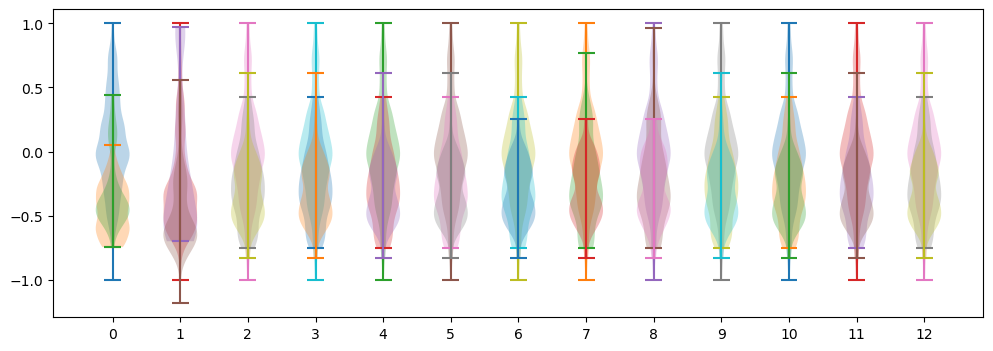

In [21]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(13):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(13)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

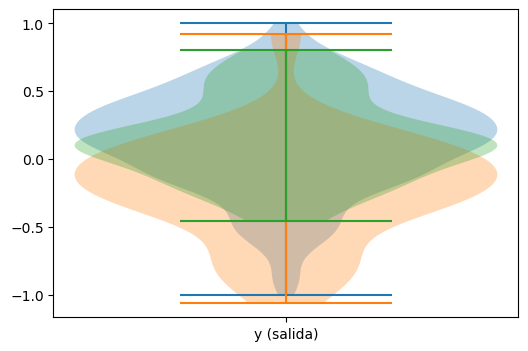

In [24]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

## Entrenamiento del Modelo

## Opcion 1:

In [28]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 5 dias x 45 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)
# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 53 # Hiperparámetro
BATCH_SIZE = 128 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

C:\Users\Cris2\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/53
3/3 - 2s - 770ms/step - loss: 0.4104 - val_loss: 0.4518
Epoch 2/53
3/3 - 0s - 55ms/step - loss: 0.3801 - val_loss: 0.4673
Epoch 3/53
3/3 - 0s - 54ms/step - loss: 0.3705 - val_loss: 0.4807
Epoch 4/53
3/3 - 0s - 51ms/step - loss: 0.3661 - val_loss: 0.4907
Epoch 5/53
3/3 - 0s - 52ms/step - loss: 0.3636 - val_loss: 0.4974
Epoch 6/53
3/3 - 0s - 54ms/step - loss: 0.3618 - val_loss: 0.5017
Epoch 7/53
3/3 - 0s - 60ms/step - loss: 0.3604 - val_loss: 0.5044
Epoch 8/53
3/3 - 0s - 54ms/step - loss: 0.3591 - val_loss: 0.5059
Epoch 9/53
3/3 - 0s - 50ms/step - loss: 0.3580 - val_loss: 0.5066
Epoch 10/53
3/3 - 0s - 58ms/step - loss: 0.3569 - val_loss: 0.5069
Epoch 11/53
3/3 - 0s - 64ms/step - loss: 0.3559 - val_loss: 0.5067
Epoch 12/53
3/3 - 0s - 63ms/step - loss: 0.3550 - val_loss: 0.5063
Epoch 13/53
3/3 - 0s - 59ms/step - loss: 0.3541 - val_loss: 0.5058
Epoch 14/53
3/3 - 0s - 53ms/step - loss: 0.3532 - val_loss: 0.5051
Epoch 15/53
3/3 - 0s - 52ms/step - loss: 0.3524 - val_loss: 0.5043
Epo

## Opcion 2 

In [30]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 5 dias x 45 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Jugar con esta funcion de activacion
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)
# Agregar mas capas y mas numero de neuronas


# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=0.01) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 100 # Hiperparámetro
BATCH_SIZE = 128 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/100


C:\Users\Cris2\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 - 2s - 578ms/step - loss: 0.6606 - val_loss: 0.4487
Epoch 2/100
3/3 - 0s - 65ms/step - loss: 0.3867 - val_loss: 0.4973
Epoch 3/100
3/3 - 0s - 54ms/step - loss: 0.3630 - val_loss: 0.5056
Epoch 4/100
3/3 - 0s - 60ms/step - loss: 0.3528 - val_loss: 0.5028
Epoch 5/100
3/3 - 0s - 52ms/step - loss: 0.3498 - val_loss: 0.4990
Epoch 6/100
3/3 - 0s - 52ms/step - loss: 0.3470 - val_loss: 0.4945
Epoch 7/100
3/3 - 0s - 53ms/step - loss: 0.3441 - val_loss: 0.4875
Epoch 8/100
3/3 - 0s - 59ms/step - loss: 0.3409 - val_loss: 0.4743
Epoch 9/100
3/3 - 0s - 52ms/step - loss: 0.3370 - val_loss: 0.4519
Epoch 10/100
3/3 - 0s - 53ms/step - loss: 0.3333 - val_loss: 0.5031
Epoch 11/100
3/3 - 0s - 51ms/step - loss: 0.3456 - val_loss: 0.5078
Epoch 12/100
3/3 - 0s - 56ms/step - loss: 0.3547 - val_loss: 0.4699
Epoch 13/100
3/3 - 0s - 60ms/step - loss: 0.3246 - val_loss: 0.4682
Epoch 14/100
3/3 - 0s - 63ms/step - loss: 0.3164 - val_loss: 0.4444
Epoch 15/100
3/3 - 0s - 54ms/step - loss: 0.3184 - val_loss: 0.4601


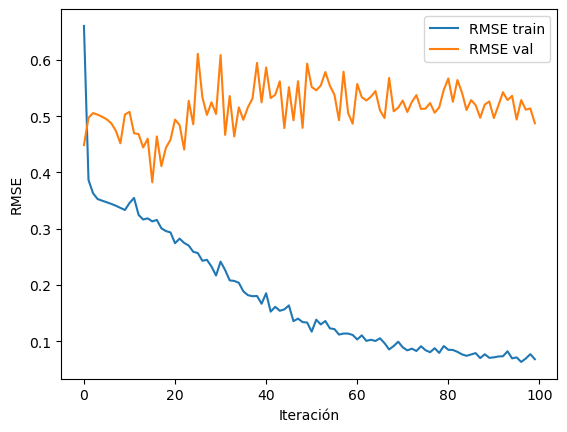

In [32]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

## Evaluacion del modelo

In [35]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.089
  RMSE val:	 0.488
  RMSE test:	 0.362


Forma de y_ts_s: (29, 2, 1)
Forma de y_ts_pred_s: (29, 2)


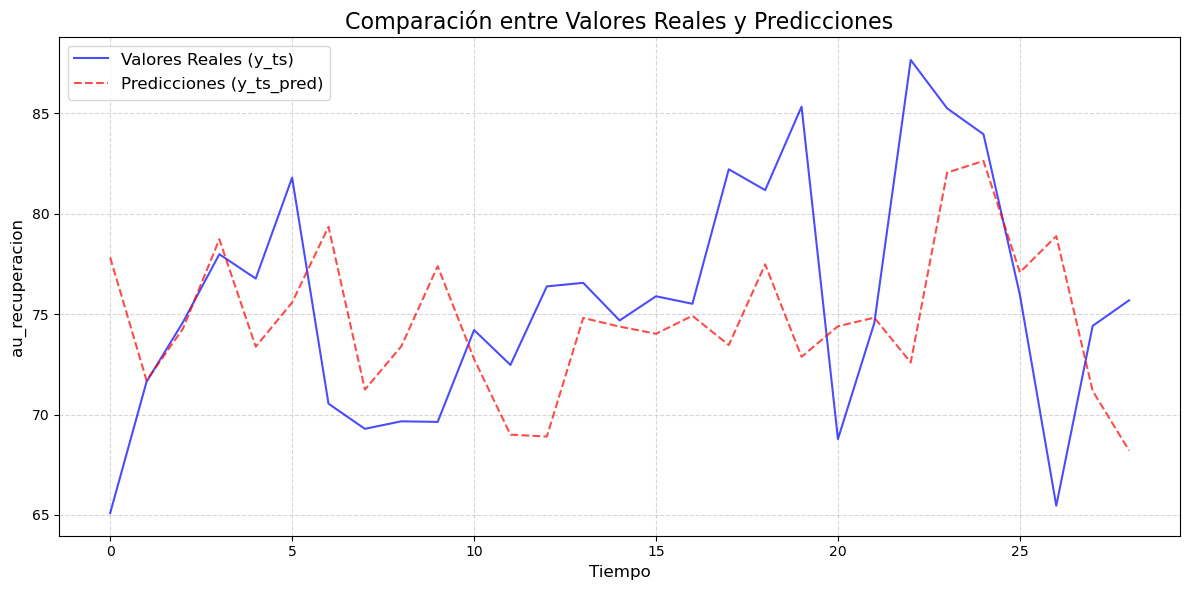

In [37]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Generar las predicciones sobre el set de prueba
y_ts_pred_s = modelo.predict(x_ts_s, verbose=0)

# 2. Verificar las formas de los arrays
print(f"Forma de y_ts_s: {y_ts_s.shape}")
print(f"Forma de y_ts_pred_s: {y_ts_pred_s.shape}")

# 3. Ajustar las formas si es necesario
if len(y_ts_s.shape) == 3:
    y_ts_s = np.squeeze(y_ts_s, axis=-1)
if len(y_ts_pred_s.shape) == 3:
    y_ts_pred_s = np.squeeze(y_ts_pred_s, axis=-1)

# 4. Realizar la transformación inversa de las predicciones
y_ts_original = scaler.inverse_transform(y_ts_s)
y_ts_pred = scaler.inverse_transform(y_ts_pred_s)

# 5. Graficar los datos de prueba y las predicciones
plt.figure(figsize=(12, 6))

# Graficar los datos de prueba (valores reales)
plt.plot(y_ts_original[:, 0], label='Valores Reales (y_ts)', color='blue', alpha=0.7)

# Graficar las predicciones del modelo
plt.plot(y_ts_pred[:, 0], label='Predicciones (y_ts_pred)', color='red', linestyle='--', alpha=0.7)

# Personalizar la gráfica
plt.title('Comparación entre Valores Reales y Predicciones', fontsize=16)
plt.xlabel('Tiempo', fontsize=12)
plt.ylabel('au_recuperacion', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()

# Mostrar la gráfica
plt.show()

In [39]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MSE: {mse}')

MSE: 0.131361005621888


In [41]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MAE: {mae}')

MAE: 0.27422780645195677


In [43]:
from sklearn.metrics import r2_score

r2 = r2_score(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'R²: {r2}')

R²: -0.3622918335487353


In [45]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y_ts_s.reshape(-1, 1), y_ts_pred_s.reshape(-1, 1))
print(f'MAPE: {mape}%')

MAPE: 129.15776414887668%
